In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download and Prepare the Dataset

### donload the original images

In [ ]:
!wget -P /content/drive/MyDrive/dental-segmentation/raw-dataset https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hxt48yk462-1.zip

--2023-05-31 12:04:12--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hxt48yk462-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.98.56, 52.218.104.43, 3.5.69.139, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.98.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 325134124 (310M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/dental-segmentation/raw-dataset/hxt48yk462-1.zip’

hxt48yk462-1.zip    100%[===================>] 310.07M  17.6MB/s    in 17s     

2023-05-31 12:04:30 (17.8 MB/s) - ‘/content/drive/MyDrive/dental-segmentation/raw-dataset/hxt48yk462-1.zip’ saved [325134124/325134124]



In [60]:
import zipfile
import os
import shutil

original_images_dataset_zip = '/content/drive/MyDrive/dental-segmentation/raw-dataset/hxt48yk462-1.zip'
destination_dir = '/content/drive/MyDrive/dental-segmentation/raw-dataset'
images_dir = 'images'

# Extract the raw dataset zip file in the raw-dataset folder
with zipfile.ZipFile(original_images_dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

# Path to the extracted DentalPanoramicXrays.zip file
dental_zip_path = os.path.join(destination_dir, 'DentalPanoramicXrays.zip')
dental_extract_dir = os.path.join(destination_dir, 'DentalPanoramicXrays')

# Extract the DentalPanoramicXrays.zip file inside the DentalPanoramicXrays folder
with zipfile.ZipFile(dental_zip_path, 'r') as zip_ref:
    zip_ref.extractall(dental_extract_dir)

# Define the paths to the extracted dataset folders
source_images_dir = os.path.join(dental_extract_dir, 'Images')

# Create the destination directories
destination_images_dir = os.path.join(destination_dir, images_dir)
os.makedirs(destination_images_dir, exist_ok=True)

# Move the image files
for filename in os.listdir(source_images_dir):
    source_path = os.path.join(source_images_dir, filename)
    destination_path = os.path.join(destination_images_dir, filename)
    shutil.move(source_path, destination_path)


# Remove the extracted dataset folder and the extracted DentalPanoramicXrays.zip file and other redundant files 
shutil.rmtree(dental_extract_dir)
os.remove(dental_zip_path)

print("Original Images extraction and organization completed successfully!")

# Count the number of images
images_count = len(os.listdir(os.path.join(destination_dir, 'images')))

# Print the number of images
print("All Images:", images_count)

Original Images extraction and organization completed successfully!
All Images: 116


### donload the masks

In [ ]:
!wget https://github.com/ImagingYeditepe/Segmentation-of-Teeth-in-Panoramic-X-ray-Image/raw/main/Original_Masks/Orig_Masks.zip -P /content/drive/MyDrive/dental-segmentation/raw-dataset/

--2023-05-31 12:27:34--  https://github.com/ImagingYeditepe/Segmentation-of-Teeth-in-Panoramic-X-ray-Image/raw/main/Original_Masks/Orig_Masks.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ImagingYeditepe/Segmentation-of-Teeth-in-Panoramic-X-ray-Image/main/Original_Masks/Orig_Masks.zip [following]
--2023-05-31 12:27:34--  https://raw.githubusercontent.com/ImagingYeditepe/Segmentation-of-Teeth-in-Panoramic-X-ray-Image/main/Original_Masks/Orig_Masks.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3235413 (3.1M) [application/zip]
Saving to: ‘/content/drive/MyDrive/dental-segmentation/raw-d

In [61]:
masks_dataset_zip = '/content/drive/MyDrive/dental-segmentation/raw-dataset/Orig_Masks.zip'

destination_dir = '/content/drive/MyDrive/dental-segmentation/raw-dataset/masks'

# Create the extraction directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(masks_dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

print("Masks extraction and organization completed successfully!")
# Count the number of masks
images_count = len(os.listdir(destination_dir))

# Print the number of masks
print("All Masks:", images_count)

Masks extraction and organization completed successfully!
All Masks: 116


In [ ]:
import os
from PIL import Image

def calculate_target_size(directory):
    max_w_dim = 0
    max_h_dim = 0

    # Iterate over the images in the directory
    for image_name in os.listdir(directory):
        image_path = os.path.join(directory, image_name)
        img = Image.open(image_path)
        width, height = img.size
        max_w_dim = max(max_w_dim, width)
        max_h_dim = max(max_h_dim, height)

    target_size = (max_w_dim, max_h_dim)
    return target_size

In [ ]:
images_dir = '/content/drive/MyDrive/dental-segmentation/raw-dataset/images'
# Set the target size and batch size for the generators
batch_size = 32
target_size = calculate_target_size(images_dir)
print(f'max_dim for images are: {target_size}')

max_dim for images are: (3138, 1380)


### split the data into train and validation

In [62]:
import os
import random
import shutil

# Set the directories for images and masks
images_dir = '/content/drive/MyDrive/dental-segmentation/raw-dataset/images'
masks_dir = '/content/drive/MyDrive/dental-segmentation/raw-dataset/masks'

# Set the destination directories for train and validation
train_dir = '/content/drive/MyDrive/dental-segmentation/Data/train'
val_dir = '/content/drive/MyDrive/dental-segmentation/Data/validation'

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(os.path.join(train_dir, 'images', 'img'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'masks', 'img'), exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(os.path.join(val_dir, 'images', 'img'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'masks', 'img'), exist_ok=True)

# Get the list of image files
image_files = os.listdir(images_dir)

# Shuffle the list of image files
random.shuffle(image_files)

# Calculate the split index for train-validation split
split_index = int(0.9 * len(image_files))

# Move images and masks to train directory
for filename in image_files[:split_index]:
    source_image = os.path.join(images_dir, filename)
    source_mask = os.path.join(masks_dir, filename)
    destination_image = os.path.join(train_dir, 'images', 'img', filename)
    destination_mask = os.path.join(train_dir, 'masks', 'img', filename)
    shutil.copy(source_image, destination_image)
    shutil.copy(source_mask, destination_mask)

# Move images and masks to validation directory
for filename in image_files[split_index:]:
    source_image = os.path.join(images_dir, filename)
    source_mask = os.path.join(masks_dir, filename)
    destination_image = os.path.join(val_dir, 'images', 'img', filename)
    destination_mask = os.path.join(val_dir, 'masks', 'img', filename)
    shutil.copy(source_image, destination_image)
    shutil.copy(source_mask, destination_mask)

# Count the number of images in train and validation
train_image_count = len(os.listdir(os.path.join(train_dir, 'images', 'img')))
train_mask_count = len(os.listdir(os.path.join(train_dir, 'masks', 'img')))
val_image_count = len(os.listdir(os.path.join(val_dir, 'images', 'img')))
val_mask_count = len(os.listdir(os.path.join(val_dir, 'masks', 'img')))

# Print the number of images in train and validation
print("Train Images:", train_image_count)
print("Train Masks:", train_mask_count)
print("Validation Images:", val_image_count)
print("Validation Masks:", val_mask_count)


Train Images: 116
Train Masks: 116
Validation Images: 22
Validation Masks: 22


## load the dataset

In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

input_size = (256, 256)
# Set the directories for train and validation
train_dir = '/content/drive/MyDrive/dental-segmentation/Data/train'
val_dir = '/content/drive/MyDrive/dental-segmentation/Data/validation'

# Create the ImageDataGenerator for train and validation images and masks
train_image_data_gen = ImageDataGenerator(rescale=1.0 / 255.0)
train_mask_data_gen = ImageDataGenerator(rescale=1.0 / 255.0)
val_image_data_gen = ImageDataGenerator(rescale=1.0 / 255.0)
val_mask_data_gen = ImageDataGenerator(rescale=1.0 / 255.0)

# Use the target size and class mode in the ImageDataGenerator for train images and masks
train_image_generator = train_image_data_gen.flow_from_directory(
    directory=os.path.join(train_dir, 'images'),
    target_size=input_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=True,
    seed=42
)
train_mask_generator = train_mask_data_gen.flow_from_directory(
    directory=os.path.join(train_dir, 'masks'),
    target_size=input_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=True,
    seed=42
)

# Use the target size and class mode in the ImageDataGenerator for validation images and masks
val_image_generator = val_image_data_gen.flow_from_directory(
    directory=os.path.join(val_dir, 'images'),
    target_size=input_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=True,
    seed=42
)
val_mask_generator = val_mask_data_gen.flow_from_directory(
    directory=os.path.join(val_dir, 'masks'),
    target_size=input_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=True,
    seed=42
)

# Create the train and validation generators
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 116 images belonging to 1 classes.
Found 116 images belonging to 1 classes.
Found 22 images belonging to 1 classes.
Found 22 images belonging to 1 classes.


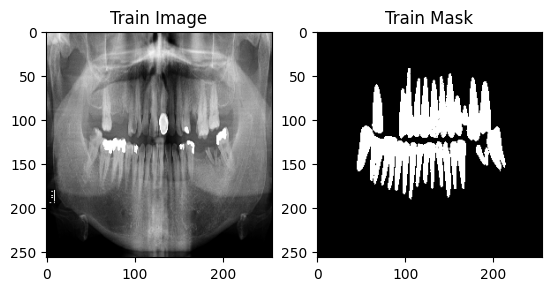

image shape:(1, 256, 256, 3), mask shape:(1, 256, 256, 3)


In [64]:
import random
import matplotlib.pyplot as plt

# Set the random index
index = random.randint(0, len(train_image_generator) - 1)

# Retrieve the image and mask using the random index
image = train_image_generator._get_batches_of_transformed_samples([index])
mask = train_mask_generator._get_batches_of_transformed_samples([index])

# Display the image and mask
plt.subplot(1, 2, 1)
plt.imshow(image[0])
plt.title('Train Image')

plt.subplot(1, 2, 2)
plt.imshow(mask[0])
plt.title('Train Mask')

plt.show()
print(f'image shape:{image.shape}, mask shape:{mask.shape}')

## U-Net Model

### define the model

In [65]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# Define the U-Net model
def unet(input_size):
    # Input layer
    inputs = Input(shape=input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same')(up6)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same')(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same')(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    # Create the model
    model = Model(inputs=inputs, outputs=conv10)

    return model

# Create the U-Net model
model = unet((256, 256, 3))


In [66]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_138 (Conv2D)            (None, 256, 256, 64  1792        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_139 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_138[0][0]']             
                                )                                                           

### Compile the model

In [75]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

### Train the model

In [76]:
history = model.fit(train_generator, steps_per_epoch=14, epochs=10, validation_data=val_generator, validation_steps=14, verbose=1)

Epoch 1/10
14/14 [==============================] - 39s 2s/step - loss: 0.4797 - accuracy: 0.8448 - val_loss: 0.2284 - val_accuracy: 0.9006
Epoch 2/10
14/14 [==============================] - 21s 2s/step - loss: 0.2247 - accuracy: 0.8992 - val_loss: 0.1961 - val_accuracy: 0.9125
Epoch 3/10
14/14 [==============================] - 25s 2s/step - loss: 0.2049 - accuracy: 0.9082 - val_loss: 0.1786 - val_accuracy: 0.9263
Epoch 4/10
14/14 [==============================] - 22s 2s/step - loss: 0.1903 - accuracy: 0.9132 - val_loss: 0.1708 - val_accuracy: 0.9298
Epoch 5/10
14/14 [==============================] - 21s 2s/step - loss: 0.1834 - accuracy: 0.9191 - val_loss: 0.1727 - val_accuracy: 0.9284
Epoch 6/10
14/14 [==============================] - 21s 2s/step - loss: 0.1851 - accuracy: 0.9187 - val_loss: 0.1655 - val_accuracy: 0.9297
Epoch 7/10
14/14 [==============================] - 21s 2s/step - loss: 0.1701 - accuracy: 0.9259 - val_loss: 0.2527 - val_accuracy: 0.8579
Epoch 8/10
14/14 [==

### Save the training model

In [77]:
model.save('/content/drive/MyDrive/dental-segmentation/save/unet_model.h5')

### predict on validation test

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of validation images and masks
val_images, val_masks = next(val_generator)

# Make predictions
predictions = model.predict(val_images)

# Threshold the predictions
threshold = 0.5
predictions[predictions >= threshold] = 1
predictions[predictions < threshold] = 0

# Convert the predictions to masks
predicted_masks = predictions * 255
predicted_masks = predicted_masks.astype(np.uint8)

1/1 [==============================] - 0s 37ms/step


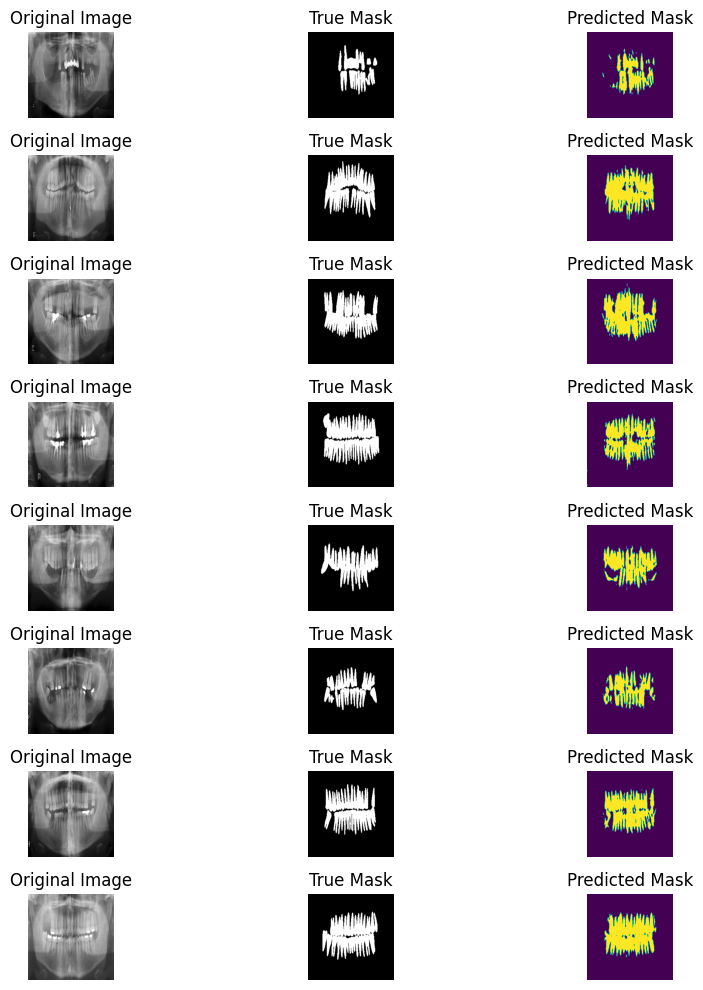

In [84]:
# Display the original image, true mask, and predicted mask
fig, axs = plt.subplots(len(val_images), 3, figsize=(10, 10))

for i in range(len(val_images)):
    axs[i, 0].imshow(val_images[i])
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original Image')

    axs[i, 1].imshow(val_masks[i])
    axs[i, 1].axis('off')
    axs[i, 1].set_title('True Mask')

    axs[i, 2].imshow(predicted_masks[i])
    axs[i, 2].axis('off')
    axs[i, 2].set_title('Predicted Mask')

plt.tight_layout()
plt.show()


In [85]:
# Calculate accuracy for each image
accuracies = []
for i in range(len(val_images)):
    true_mask = val_masks[i]
    predicted_mask = predicted_masks[i]
    accuracy = np.mean(true_mask == predicted_mask)
    accuracies.append(accuracy)

# Print the accuracy for each image
for i, accuracy in enumerate(accuracies):
    print(f"Accuracy for image {i+1}: {accuracy}")

# Calculate the overall accuracy
overall_accuracy = np.mean(accuracies)
print(f"Overall accuracy: {overall_accuracy}")

Accuracy for image 1: 0.8654022216796875
Accuracy for image 2: 0.76068115234375
Accuracy for image 3: 0.759918212890625
Accuracy for image 4: 0.731903076171875
Accuracy for image 5: 0.807525634765625
Accuracy for image 6: 0.838409423828125
Accuracy for image 7: 0.774444580078125
Accuracy for image 8: 0.7603302001953125
Overall accuracy: 0.7873268127441406


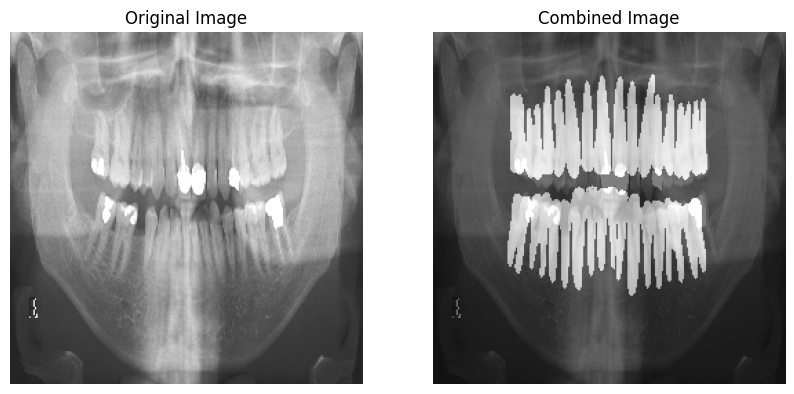

In [122]:
import cv2
import matplotlib.pyplot as plt

val_images, val_masks = next(val_generator)

# Get the first image and mask from the validation set
image = val_images[0]
mask = val_masks[0]

# Add the image and mask together
result = cv2.addWeighted(image, 0.5, mask, 0.5, 0)

# Display the result using Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(result)
axes[1].set_title('Combined Image')
axes[1].axis('off')
plt.show()
